In [533]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from math import e
from haversine import haversine
import statistics

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [456]:
data = pd.read_csv('../regression_data_clean.csv')

In [457]:
# Defining column meanings.

##### - id:  Identificator for each different property. <br>- date:  Date that the property was sold. <br>- bedrooms:  Number of bedrooms inside the property. <br>- bathrooms:  Number of bathrooms inside the property. <br>- sqft_living:  Living  area in the property.<br> - sqft_lot:  Total area of the property. <br> - floors:  Number of floors of the property. <br>- waterfront:  Property has a waterfront or not. <br>- view:  How many times the house has been viewed. <br> - condition:  Condition of the house. <br> - grade:  Grade that the house has based on certain parameters. <br>- sqft_above: Sqft of the house without the basement. <br> - sqft_basement:  Sqft of house basement. <br> - yr_built: Year the house was built. <br> - yr_renovated:  Year the house was renovated; if it's never been renovated will yr_renovated = 0. <br> - zipcode: zipcode that the house is in. <br> - lat: Location based on latitude. <br> - long: Location based on longitude. <br> - sqft_living15: Living area in the property by year 2015. <br> - sqft_lot15:  Total area of the property by year 2015. <br> - price: Price of the property.

In [458]:
### Checking datatypes, null and nan's values, and statistical details in dataset

In [459]:
# Check data types

In [460]:
data.dtypes

id                 int64
date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

##### At a first glance, we can see that apart from the column date, the rest of the variables are treated as numerical data. First observation is that even though 'id' is considered as a numerical, it actually and identificator for each house(not for each sale, as will see later, some houses are duplicated, because they were sold in both of the years thatare in the dataset). We might also reconsider later on to treat some of the numerical variables as categorical ordinal(ex: bedrooms, view, zipcode)

In [461]:
### Check for nan'n/null values

In [462]:
data.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

##### We find that no nan values are found in our data set, this means that there are not empty fields, there might be 0's but those 0's have a meanning. 

In [463]:
### Check for duplicates in the ID column to see if a property is more than one time in the dataset.

In [464]:
duplicates = data[data['id'].duplicated(keep=False) == True]
duplicates.head(6)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
93,6021501535,7/25/14,3,1.50,1580,5000,1.0,0,0,3,...,1290,290,1939,0,98117,47.6870,-122.386,1570,4500,430000
94,6021501535,12/23/14,3,1.50,1580,5000,1.0,0,0,3,...,1290,290,1939,0,98117,47.6870,-122.386,1570,4500,700000
313,4139480200,6/18/14,4,3.25,4290,12103,1.0,0,3,3,...,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244,1380000
314,4139480200,12/9/14,4,3.25,4290,12103,1.0,0,3,3,...,2690,1600,1997,0,98006,47.5503,-122.102,3860,11244,1400000
324,7520000520,9/5/14,2,1.00,1240,12092,1.0,0,0,3,...,960,280,1922,1984,98146,47.4957,-122.352,1820,7460,232000
325,7520000520,3/11/15,2,1.00,1240,12092,1.0,0,0,3,...,960,280,1922,1984,98146,47.4957,-122.352,1820,7460,240500


##### We observe that some id's are repeated, and that the dates and prices are different. Therefore we can asume that the property was bougth and selled again between the two years represented in the dataframe. We proceed then to drop the rows where the data is earlier and keep the ones that were lastly bought.

In [465]:
### Drop duplicated columns.

In [466]:
data_nodup2 = data.sort_values('date').drop_duplicates('id',keep='last')
data_nodup = data_nodup2.sort_index(ignore_index=True)

In [467]:
### Check the new shape of the dataframe

In [468]:
data_nodup

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,263000018,5/21/14,3,2.50,1530,1131,3.0,0,0,3,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,360000
21416,6600060120,2/23/15,4,2.50,2310,5813,2.0,0,0,3,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,400000
21417,1523300141,6/23/14,2,0.75,1020,1350,2.0,0,0,3,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,402101
21418,291310100,1/16/15,3,2.50,1600,2388,2.0,0,0,3,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,400000


##### 157 rows have been dropped

#### Describe method to show the statistical details of the dataset.

In [469]:
data_nodup.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.142000e+04,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.00000,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04
mean,4.580940e+09,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.007610,0.235107,3.410784,7.662792,1791.170215,291.962418,1971.092997,84.793091,98077.87437,47.560197,-122.213784,1988.384080,12775.718161,5.410746e+05
std,2.876761e+09,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.086903,0.767165,0.650035,1.171971,828.692965,442.875502,29.387141,402.574626,53.47748,0.138589,0.140791,685.537057,27345.621867,3.678126e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,0.000000,98001.00000,47.155900,-122.519000,399.000000,651.000000,7.800000e+04
25%,2.123537e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1952.000000,0.000000,98033.00000,47.471200,-122.328000,1490.000000,5100.000000,3.230000e+05
50%,3.904921e+09,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.00000,47.572100,-122.230000,1840.000000,7620.000000,4.500000e+05
75%,7.308900e+09,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2220.000000,560.000000,1997.000000,0.000000,98117.00000,47.678100,-122.125000,2370.000000,10086.250000,6.450000e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.00000,47.777600,-121.315000,6210.000000,871200.000000,7.700000e+06


##### The maximum value for bedrooms is 33, we'll check that case in order to see if it's a correct value or not.

In [470]:
data_nodup[data['bedrooms'] == 33]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
15856,259601100,5/13/14,5,2.0,2290,7125,1.0,0,0,3,...,1190,1100,1964,0,98008,47.634,-122.119,1460,7920,580000


##### We see that this property has a total of 33 bedrooms in 1620 sqft_living, supposing that all rooms have the same size, each room will measure around 5 square metes. Also, there is a total of 1.75 bathrooms for the total of the property. Based on these considerations, we assume that there's a maybe a typo. We're removing the column anyway as it belongs to the range of prices in the majority class. 

In [471]:
data_nodup = data_nodup.drop(data_nodup[data_nodup['bedrooms'] == 33].index) 

In [472]:
# Select numerical variables in order to perform a correlation matrix, also drop id and date variables

In [473]:
numeric = data_nodup.drop(['id', 'date'], axis=1).select_dtypes(include='number')

In [474]:
### Check for normality

In [475]:
continous = numeric[['sqft_living','sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']]

sqft_living


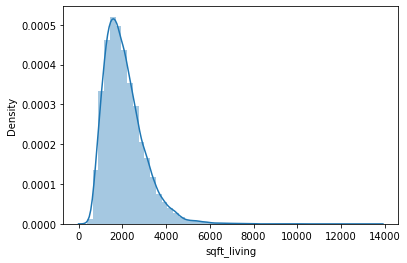

sqft_lot


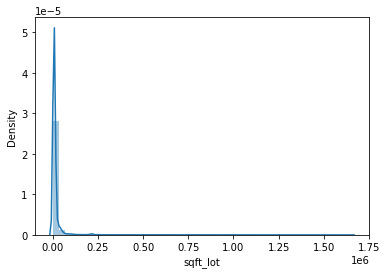

sqft_above


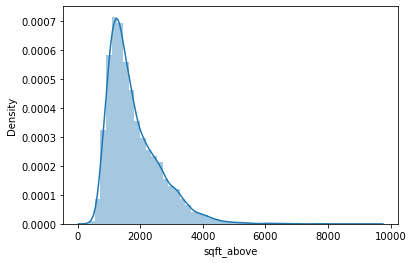

sqft_basement


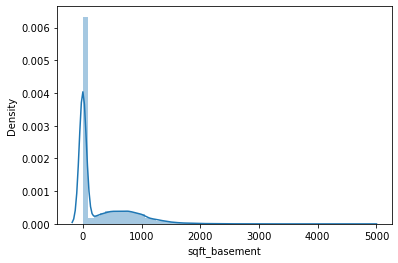

sqft_living15


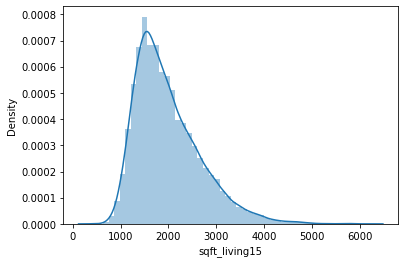

sqft_lot15


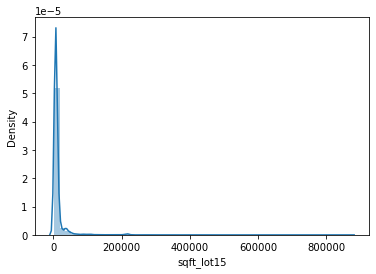

price


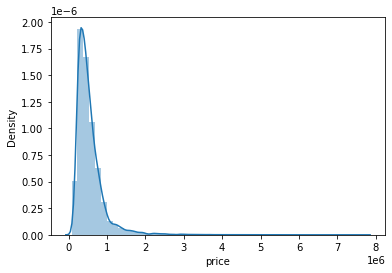

In [476]:
for x in continous:
    print(x)
    sns.distplot(continous[x])
    plt.show()

##### We observe that no  numerical value has a normal distribution. In general the skewness is high. We might perform some log-transformations in order to help the model do better predictions.

### Check for correlation between variables

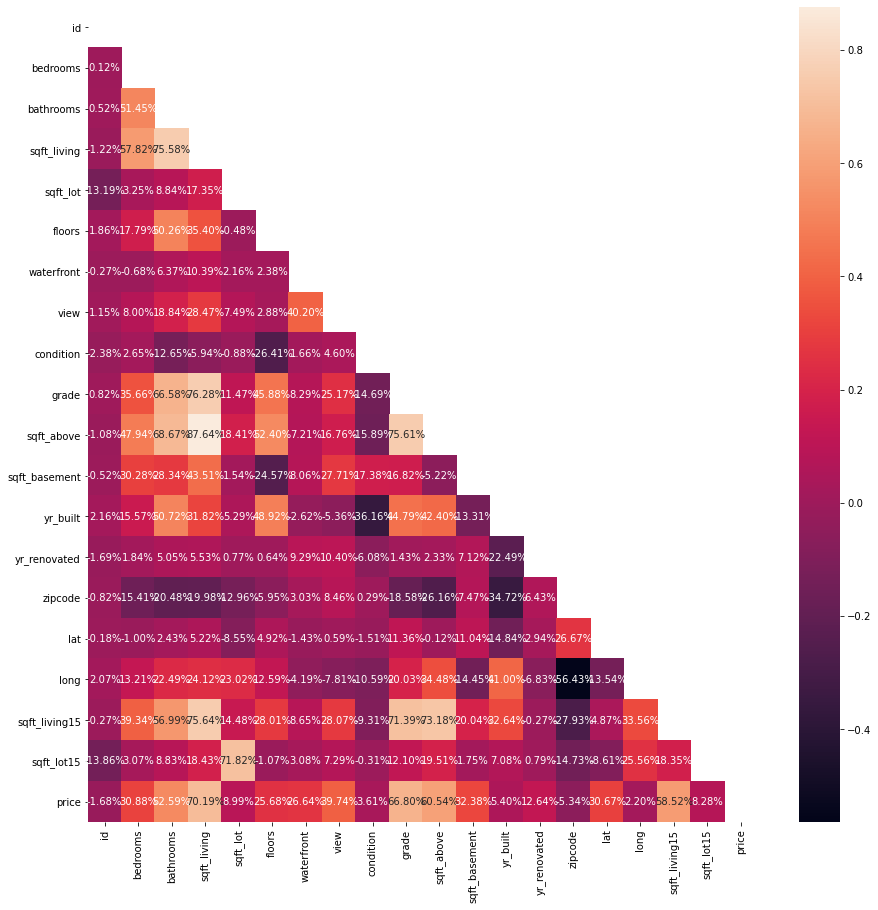

In [477]:
corr = data.corr('pearson')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

pearson_meth =data.corr('pearson')
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, mask=mask, annot=True, fmt='.2%')
plt.show()

##### Variables correlated above 60% -- > sft_living, grade, sqft_above. <br> Variables correlated above 50% -- > bathrooms, sqft_living15. <br> Variables correlated above 30% -- > bedrooms, view, sqft_basement, lat. <br> Variables correlated above 20% -- > floors, waterfront. <br> Variables correlated bellow 20% -- > sqft_lot, condition, yr_built, yr_renovated, zipcode, long, sqft_lot15 

##### We'll perform a VIF test to check for multicollinearity and find which independent variables might be defined by other independent variables.

In [478]:
y, X = dmatrices('price ~ bedrooms+bathrooms+sqft_living+floors+waterfront+view+sqft_lot+condition+grade+sqft_above+yr_built+yr_renovated+zipcode+lat+long+sqft_lot15+sqft_living15',data=data_nodup, return_type='dataframe')

In [479]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [480]:
round(vif,3)

,VIF,variable
0,4593138.705,Intercept
1,1.714,bedrooms
2,3.378,bathrooms
3,8.736,sqft_living
4,2.011,floors
5,1.206,waterfront
6,1.437,view
7,2.098,sqft_lot
8,1.254,condition
9,3.425,grade


In [481]:
##### sqft_living and sqft_above show a strong multicollinearity. Try to remove the less significant one in order to see if the multicollinearity is reduced.

In [482]:
y, X = dmatrices('price ~ bedrooms+bathrooms+sqft_living+floors+waterfront+view+sqft_lot+condition+grade++yr_built+yr_renovated+zipcode+lat+long+sqft_lot15+sqft_living15',data=data_nodup, return_type='dataframe')

In [483]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [484]:
round(vif,3)

,VIF,variable
0,4503144.026,Intercept
1,1.713,bedrooms
2,3.296,bathrooms
3,5.089,sqft_living
4,1.619,floors
5,1.204,waterfront
6,1.399,view
7,2.096,sqft_lot
8,1.245,condition
9,3.355,grade


###### We still see moderate high multicollinearity in the sqft_living variable, we're going now to remove the variable 'bathrooms' as is kind of high correlated. We're not removing the sqft_living variable as it's the one with a higher correlation with the dependent variable.

In [485]:
y, X = dmatrices('price ~ bedrooms+sqft_living+floors+waterfront+view+sqft_lot+condition+grade++yr_built+yr_renovated+zipcode+lat+long+sqft_lot15+sqft_living15',data=data_nodup, return_type='dataframe')

In [486]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [487]:
round(vif,3)

,VIF,variable
0,4497564.829,Intercept
1,1.643,bedrooms
2,4.215,sqft_living
3,1.542,floors
4,1.204,waterfront
5,1.396,view
6,2.096,sqft_lot
7,1.237,condition
8,3.343,grade
9,2.161,yr_built


###### Now no VIF indicator is above 5, so no independent variables are defined by others.

###### Take into account that some of the variables like grade, will be considered later on as ordinal classificators and therefore dummified. The correlation with grade and Price is also strong as this is a measure created to classify the house and therefore it's selling price. 

In [488]:
numeric = numeric.drop(['bathrooms', 'sqft_above'],axis=1)
numeric

,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,3,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,3,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,2,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,4,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,3,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,1800,7503,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,3,1530,1131,3.0,0,0,3,8,0,2009,0,98103,47.6993,-122.346,1530,1509,360000
21416,4,2310,5813,2.0,0,0,3,8,0,2014,0,98146,47.5107,-122.362,1830,7200,400000
21417,2,1020,1350,2.0,0,0,3,7,0,2009,0,98144,47.5944,-122.299,1020,2007,402101
21418,3,1600,2388,2.0,0,0,3,8,0,2004,0,98027,47.5345,-122.069,1410,1287,400000


### Dummify

###### Now that we worked on our numerical data, and we understood the correlation between the independent variables and the dependent variable, and we undestood and fixed multicolinearity within some of the dataset variables, we can proceed to treat with categorical data. <br><br> As pointed above, a good candidate for categorical data is the variable grade as is a classification indicator. Also 'zipcode' variable will also be dummified as it's an identifier for the different areas of a city. 

In [489]:
dummy = pd.get_dummies(data=data_nodup[['grade','zipcode']], columns=['grade','zipcode'],drop_first=True)

In [490]:
numeric = numeric.drop(['price','zipcode','grade'], axis=1)

In [491]:
#### Try the results for with the dummified data.

In [536]:
X = pd.concat([numeric, dummy],axis=1)
y = data_nodup['price']

In [493]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [494]:
model = LinearRegression().fit(X_train,y_train)

In [495]:
predictions = model.predict(X_test)

In [496]:
MAE = round(mean_absolute_error(y_test, predictions),3)
MSE = round(mean_squared_error(y_test, predictions),3)
RMSE = round(np.sqrt(MSE),3)
r_sq = round(r2_score(y_test,predictions),3)
Adj_r2 = round(1-(1-r_sq)*(21420-1)/(21420-97-1),3)
print('MAE:',MAE,'  MSE:', MSE, '  RMSE:',RMSE,'  r_sq:',r_sq, ' Adj_r2:', Adj_r2)

MAE: 90301.911   MSE: 21502364356.093   RMSE: 146636.845   r_sq: 0.842  Adj_r2: 0.841


#### Remove numerical columns

###### By dummifying 'grade' and 'zipcode' and using all the numerical values apart from 'sqft_above' and 'bathrooms' we get and R2 of 0.84 and a RMSE of 146636.845. We'll now proceed to see how the model would improve if we were to remove some other variables.

###### We'll then now see if the model improves by removing some of the numerical values that we might consider repetitive or irrelevant -- > sqft_living15 it refers to a measure taken on the year 2015 and i's very similar to sqft_living which is more correlated with the dependent variable.

In [497]:
X2 = X.drop(['sqft_living15'],axis=1)
y2 = data_nodup['price']

In [498]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=43)

In [499]:
model = LinearRegression().fit(X_train,y_train)

In [500]:
predictions2 = model.predict(X_test)

In [501]:
MAE = round(mean_absolute_error(y_test, predictions2),3)
MSE = round(mean_squared_error(y_test, predictions2),3)
RMSE = round(np.sqrt(MSE),3)
r_sq = round(r2_score(y_test,predictions),3)
Adj_r2 = round(1-(1-r_sq)*(21420-1)/(21420-97-1),3)
print('MAE:',MAE,'  MSE:', MSE, '  RMSE:',RMSE,'  r_sq:',r_sq, ' Adj_r2:', Adj_r2)

MAE: 90358.827   MSE: 21542900905.257   RMSE: 146775.001   r_sq: 0.842  Adj_r2: 0.841


###### The model doesn't improves, it actually increases slightly the MAE and the RMSE.

### Location

###### As we have two variables that are not giving us much information at the moment (lat,long) we're going to combine them, and use them to calculate the distance from the property to the significant city centers Bellevue and Seattle,  in order to see if we can extract some more information from them.

In [502]:
data['location'] = tuple(zip(data['lat'],data['long']))

In [503]:
bellevue = tuple([47.61555, -122.20392])
type(bellevue)
seattle = tuple([47.6062100, -122.3320700])

In [504]:
bell_distances = []
for i in data['location']:
    bell_distances.append(haversine((bellevue),(i),unit = 'mi'))
bell_distances[:5]

[7.622786019543605,
 9.041881842429499,
 8.561144732081049,
 10.979730087958123,
 7.402273389165363]

In [505]:
seattle_distances = []
for i in data['location']:
    seattle_distances.append(haversine((seattle),(i),unit = 'mi'))
bell_distances[:5]

[7.622786019543605,
 9.041881842429499,
 8.561144732081049,
 10.979730087958123,
 7.402273389165363]

In [506]:
numeric['distance_from_bellevue'] = pd.Series(bell_distances)
numeric['distance_from_seattle'] = pd.Series(seattle_distances)

In [508]:
numeric = numeric.drop(['lat','long'],axis=1)

In [510]:
X = pd.concat([numeric, dummy],axis=1)

In [511]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [512]:
model = LinearRegression().fit(X_train,y_train)

In [513]:
predictions = model.predict(X_test)

In [514]:
MAE = round(mean_absolute_error(y_test, predictions),3)
MSE = round(mean_squared_error(y_test, predictions),3)
RMSE = round(np.sqrt(MSE),3)
r_sq = round(r2_score(y_test,predictions),3)
Adj_r2 = round(1-(1-r_sq)*(21420-1)/(21420-97-1),3)
print('MAE:',MAE,'  MSE:', MSE, '  RMSE:',RMSE,'  r_sq:',r_sq, ' Adj_r2:', Adj_r2)

MAE: 90294.378   MSE: 21549083318.147   RMSE: 146796.06   r_sq: 0.842  Adj_r2: 0.841


###### In my particular case the model didn't improve that much as I did first the dummifying for the categorical columns zipcode and grade.

### Log Transformation

###### As we observed above, the continous values don't have a normal distribution, this might hurt the performance of the model. We'll now perform some logarithmic transformations in order to see if the model improves.

In [515]:
numeric2 = numeric
numeric2

,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,distance_from_bellevue,distance_from_seattle
0,3,1180,5650,1.0,0,0,3,0,1955,0,1340,5650,7.622786,7.439444
1,3,2570,7242,2.0,0,0,3,400,1951,1991,1690,7639,9.041882,7.954518
2,2,770,10000,1.0,0,0,3,0,1933,0,2720,8062,8.561145,10.199793
3,4,1960,5000,1.0,0,0,5,910,1965,0,1360,5000,10.979730,6.549393
4,3,1680,8080,1.0,0,0,3,0,1987,0,1800,7503,7.402273,13.391606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,3,1530,1131,3.0,0,0,3,0,2009,0,1530,1509,14.228350,20.228661
21416,4,2310,5813,2.0,0,0,3,0,2014,0,1830,7200,9.911029,4.816871
21417,2,1020,1350,2.0,0,0,3,0,2009,0,1020,2007,7.351709,9.584115
21418,3,1600,2388,2.0,0,0,3,0,2004,0,1410,1287,7.921420,4.420842


In [516]:
numeric2['log_sqft_living'] = np.log(numeric2['sqft_living'])
numeric2['log_sqft_lot'] = np.log(numeric2['sqft_lot'])
y = np.log(data_nodup['price'])


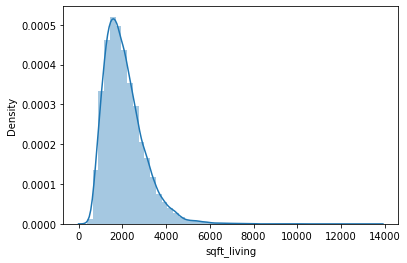

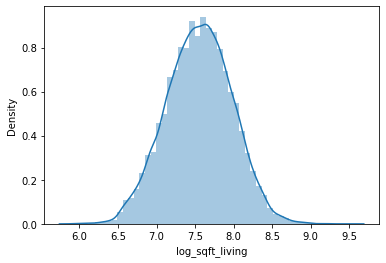

In [517]:
sns.distplot(data_nodup['sqft_living'])
plt.show()
sns.distplot(numeric['log_sqft_living'])
plt.show()

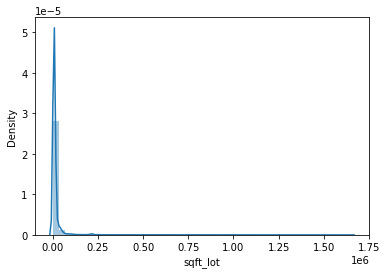

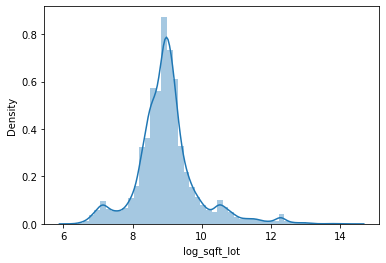

In [518]:
sns.distplot(data_nodup['sqft_lot'])
plt.show()
sns.distplot(numeric['log_sqft_lot'])
plt.show()

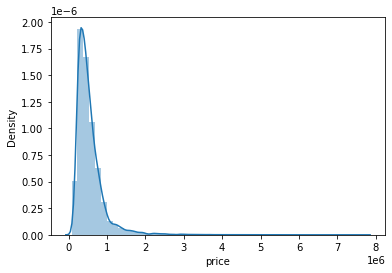

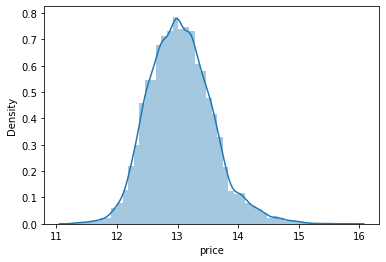

In [519]:
sns.distplot(data_nodup['price'])
plt.show()
sns.distplot(y)
plt.show()

In [522]:
X = pd.concat([numeric2, dummy],axis=1).drop(['sqft_living','sqft_lot'], axis=1)

###### Then remove the variables that have being transformed to its logarithms.

In [524]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [525]:
model = LinearRegression().fit(X_train,y_train)

In [526]:
predictions = e**(model.predict(X_test))
y_test = e**(y_test)

In [527]:
MAE = round(mean_absolute_error(y_test, predictions),3)
MSE = round(mean_squared_error(y_test, predictions),3)
RMSE = round(np.sqrt(MSE),3)
r_sq = round(r2_score(y_test,predictions),3)
Adj_r2 = round(1-(1-r_sq)*(21420-1)/(21420-97-1),3)
print('MAE:',MAE,'  MSE:', MSE, '  RMSE:',RMSE,'  r_sq:',r_sq, ' Adj_r2:', Adj_r2)

MAE: 73536.149   MSE: 15655232859.131   RMSE: 125120.873   r_sq: 0.885  Adj_r2: 0.884


In [531]:
y_t = list(y_test)
y_pred = predictions

In [534]:
relative_error = []
for j in range(len(predictions)):
    relative_error.append(abs(y_t[j] - y_pred[j])/y_t[j])
rel_e = statistics.mean(relative_error)

In [535]:
rel_e

0.1358777756513149